# **Assignment-4**

**Name:** Pavan Pandya

**Email:** pnpandya@iu.edu

## **Setup**

In [1]:
import os
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

import multiprocessing
num_workers = multiprocessing.cpu_count() - 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
import random

def set_seed(seed=42):
    # Set Python's random seed
    random.seed(seed)
    
    # Set NumPy's random seed
    np.random.seed(seed)
    
    # Set PyTorch's random seed for CPU
    torch.manual_seed(seed)
    
    # Set PyTorch's random seed for GPU (if using)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Ensure PyTorch operations are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

In [4]:
# Define the directory paths
model_dir = '/kaggle/working/model'
output_dir = '/kaggle/working/output'

# Function to check and create directory
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory created: {directory_path}")
    else:
        print(f"Directory already exists: {directory_path}")
        
# Ensure the directory exists
create_directory(model_dir)
create_directory(output_dir)

Directory created: /kaggle/working/model
Directory created: /kaggle/working/output


## **Problem 1: RNNs as a generative model**

In [5]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 38249074.49it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1140637.42it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10592087.05it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2636021.69it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
def convert_to_patch_dataset(dataset, patch_size=7, num_patches=16):
    patches_list = []
    labels_list = []
    
    for image, label in dataset:
        # Ensure image is a 2D tensor (remove batch dimension if present)
        if image.dim() == 3:
            image = image.squeeze(0)
        
        # Extract patches 
        patches = image.unfold(0, patch_size, patch_size) \
                      .unfold(1, patch_size, patch_size) \
                      .reshape(num_patches, patch_size * patch_size)
        
        patches_list.append(patches)
        labels_list.append(label)
    
    # Convert lists to tensors
    patches_tensor = torch.stack(patches_list)
    labels_tensor = torch.tensor(labels_list)
    
    # Create a new TensorDataset
    return TensorDataset(patches_tensor, labels_tensor)

In [7]:
# Split the dataset
q1_val_size = 10000
q1_train_set, q1_val_set = random_split(mnist_train_dataset, [q1_val_size, len(mnist_train_dataset) - q1_val_size])
batch_size = 100

q1_train_loader = DataLoader(convert_to_patch_dataset(q1_train_set), batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
q1_test_loader = DataLoader(convert_to_patch_dataset(mnist_test_dataset), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
q1_val_loader = DataLoader(convert_to_patch_dataset(q1_val_set), batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [8]:
# Check the shape of the first batch to verify
print("First batch tensor shape:", next(iter(q1_train_loader))[0].shape)  # Should be (100, 16, 49)

First batch tensor shape: torch.Size([100, 16, 49])


In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=49, hidden_size=256, num_layers=3, output_size=49):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh() 

        # Initialize weights and biases
        self._init_weights()

    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.LSTM):
                for name, param in layer.named_parameters():
                    if "weight_ih" in name:
                        nn.init.kaiming_uniform_(param.data, nonlinearity="relu")
                    elif "weight_hh" in name:
                        nn.init.orthogonal_(param.data)
                    elif "bias" in name:
                        nn.init.zeros_(param.data)
            elif isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity="relu")
                nn.init.zeros_(layer.bias) 

    def forward(self, x, hidden=None):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        out = self.activation(out)
        return out, hidden

In [10]:
def train_q1_model(model, train_batches, val_batches, criterion, optimizer, device, num_epochs=50, patience=5):
    model.to(device)

    total_train_losses = []
    total_val_losses = []
    best_val_loss = float('inf')  
    epochs_without_improvement = 0  
    best_model = None

    for epoch in range(num_epochs):
        model.train()  
        total_train_loss = 0

        # Training loop for each batch
        for i, (batch_tensor, _) in enumerate(train_batches):
            batch_tensor = batch_tensor.to(device)

            # Define input sequence (X1:15) and target sequence (X2:16)
            input_seq = batch_tensor[:, :15, :]   # Shape: (batch_size, 15, 49)
            target_seq = batch_tensor[:, 1:16, :]  # Shape: (batch_size, 15, 49)
            
            # Forward pass
            optimizer.zero_grad()
            output, _ = model(input_seq)  # Shape: (batch_size, 15, 49)
            
            # Compute loss
            loss = criterion(output, target_seq)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()

        # Average training loss per batch
        avg_train_loss = total_train_loss / len(train_batches)
        total_train_losses.append(avg_train_loss)
        
        # Validation
        model.eval() 
        total_val_loss = 0
        with torch.no_grad():  
            for i, (batch_tensor, _) in enumerate(val_batches):
                batch_tensor = batch_tensor.to(device)
                
                # Define input sequence (X1:15) and target sequence (X2:16)
                input_seq = batch_tensor[:, :15, :]   # Shape: (batch_size, 15, 49)
                target_seq = batch_tensor[:, 1:16, :]  # Shape: (batch_size, 15, 49)
                
                # Forward pass
                output, _ = model(input_seq)  # Shape: (batch_size, 15, 49)
            
                # Compute loss
                loss = criterion(output, target_seq)
                total_val_loss += loss.item()

        # Average val loss per batch
        avg_val_loss = total_val_loss / len(val_batches)
        total_val_losses.append(avg_val_loss)
        
        # Print epoch results
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            best_model = model.state_dict()
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping after {epoch + 1} epochs. Validation loss stopped improving.")
                # Save the best model before breaking the loop
                torch.save(best_model, "/kaggle/working/model/q1_best_model.pth")
                break
        
        # If the loop completes without early stopping, save the best model
        if epochs_without_improvement < patience:
            torch.save(best_model, "/kaggle/working/model/q1_best_model.pth")

    return total_train_losses, total_val_losses


In [11]:
q1_model = LSTMModel().to(device)
q1_criterion = nn.MSELoss()
q1_optimizer = optim.Adam(q1_model.parameters(), lr=0.0005)
patience = 5
num_epochs = 200

In [12]:
# Train the model
q1_train_losses, q1_val_losses = train_q1_model(q1_model, q1_train_loader, q1_val_loader, q1_criterion, q1_optimizer, device, num_epochs, patience)

Epoch [1/200], Train Loss: 0.0833, Val Loss: 0.0641
Epoch [2/200], Train Loss: 0.0568, Val Loss: 0.0511
Epoch [3/200], Train Loss: 0.0483, Val Loss: 0.0458
Epoch [4/200], Train Loss: 0.0441, Val Loss: 0.0427
Epoch [5/200], Train Loss: 0.0415, Val Loss: 0.0407
Epoch [6/200], Train Loss: 0.0396, Val Loss: 0.0392
Epoch [7/200], Train Loss: 0.0383, Val Loss: 0.0382
Epoch [8/200], Train Loss: 0.0373, Val Loss: 0.0371
Epoch [9/200], Train Loss: 0.0363, Val Loss: 0.0366
Epoch [10/200], Train Loss: 0.0356, Val Loss: 0.0361
Epoch [11/200], Train Loss: 0.0349, Val Loss: 0.0353
Epoch [12/200], Train Loss: 0.0342, Val Loss: 0.0350
Epoch [13/200], Train Loss: 0.0337, Val Loss: 0.0346
Epoch [14/200], Train Loss: 0.0333, Val Loss: 0.0343
Epoch [15/200], Train Loss: 0.0328, Val Loss: 0.0339
Epoch [16/200], Train Loss: 0.0324, Val Loss: 0.0337
Epoch [17/200], Train Loss: 0.0321, Val Loss: 0.0334
Epoch [18/200], Train Loss: 0.0317, Val Loss: 0.0332
Epoch [19/200], Train Loss: 0.0313, Val Loss: 0.0329
Ep

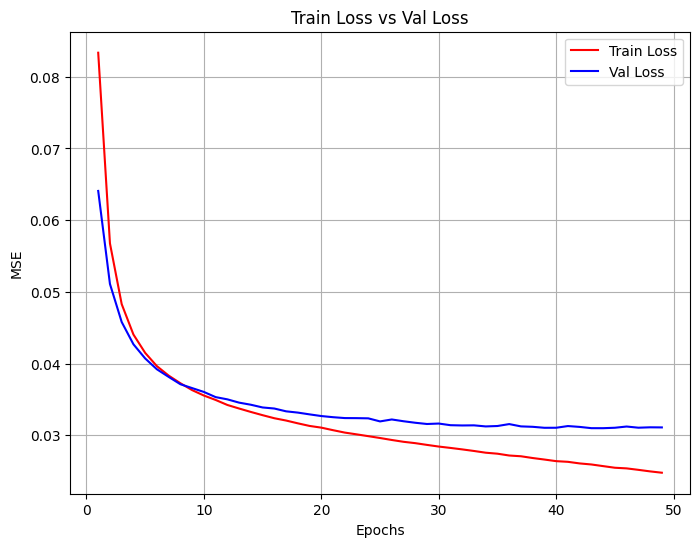

In [13]:
# Plot the train_loss vs test_loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(q1_train_losses) + 1), q1_train_losses, label='Train Loss', color='r')
plt.plot(range(1, len(q1_val_losses) + 1), q1_val_losses, label='Val Loss', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Train Loss vs Val Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
q1_best_model = LSTMModel().to(device)
q1_best_model.load_state_dict(torch.load("/kaggle/working/model/q1_best_model.pth"))

<All keys matched successfully>

In [15]:
def sample_by_class(dataloader, sample_size):
    class_samples = {}
    for data, labels in dataloader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in class_samples:
                class_samples[label] = []
            if len(class_samples[label]) < sample_size:
                class_samples[label].append((data[i], label))
        if all(len(class_samples[label]) >= sample_size for label in class_samples):
            break
    return class_samples

In [16]:
def reconstruct_image_from_patches(patches):
    image = np.zeros((28, 28))
    patch_size = 7
    
    for patch_idx, patch_data in enumerate(patches):
        row = (patch_idx // 4) * patch_size
        col = (patch_idx % 4) * patch_size
        
        image[row:row+patch_size, col:col+patch_size] = patch_data.reshape(patch_size, patch_size)
    
    return image

In [17]:
def generate_image(model, device, patches):
    model.eval()
    patches = patches.to(device)
    
    # Initialize with the first 8 input patches
    top_half_patches = patches[:8].unsqueeze(0).to(device)
    predicted_patches = []

    with torch.no_grad():
        # Predict the 9th patch
        pred_patch, hidden_state = model(top_half_patches)
        predicted_patches.append(pred_patch[:, 7:8, :]) 

        # Predict patches 10 to 16 iteratively
        for _ in range(1, 8):
            pred_patch, hidden_state = model(predicted_patches[-1], hidden_state)
            predicted_patches.append(pred_patch)

    # Combine all 16 patches into a single 7x7 image
    all_patches = [top_half_patches[:, i, :].reshape(7, 7) for i in range(8)] + [patch.reshape(7, 7) for patch in predicted_patches]

    # Form rows by concatenating 4 patches each
    rows = [torch.cat(all_patches[i:i+4], dim=1) for i in range(0, 16, 4)]

    # Combine rows to generate the final image
    generated_image = torch.cat(rows, dim=0)

    return generated_image.detach().cpu().numpy()

In [18]:
class_samples = sample_by_class(q1_test_loader, 10)

In [19]:
# Verify elements
for k in class_samples.keys():
    print(f"{k} has {len(class_samples[k])} elements.")

7 has 10 elements.
2 has 10 elements.
1 has 10 elements.
0 has 10 elements.
4 has 10 elements.
9 has 10 elements.
5 has 10 elements.
6 has 10 elements.
3 has 10 elements.
8 has 10 elements.


In [20]:
# Stores test images in a 28x28 shape, used for showing original image
generated_images = []
original_images = []

for digit in range(10):
    for img, _ in class_samples[digit]:
        original_images.append(reconstruct_image_from_patches(img.cpu().numpy()))
        # Reconstruct the original image
        generated_images.append(generate_image(q1_best_model, device, img))

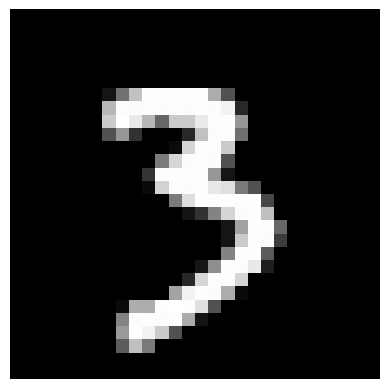

In [21]:
# Display the original image
plt.imshow(original_images[31], cmap='gray')
plt.axis('off')  
plt.show()

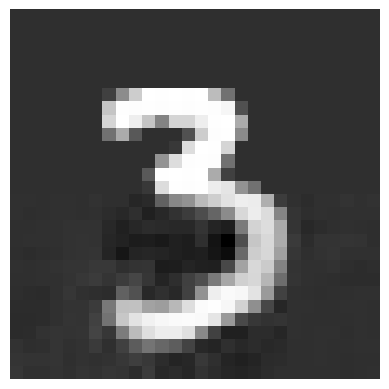

In [22]:
# Display the generated image
plt.imshow(generated_images[31], cmap='gray')
plt.axis('off')  
plt.show()

In [23]:
def visualize_images(original_images, generated_images, rows=10, cols=10):
    assert len(original_images) == len(generated_images), "Input lists must have the same length"
    total_images = len(original_images) 
    row, col = 10, 10
    
    # Plot Original Images
    plt.figure(figsize=(10, 8))
    plt.suptitle("Original Images")
    for i in range(total_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Plot Generated Images
    plt.figure(figsize=(10, 8))
    plt.suptitle("Generated Images")
    for i in range(total_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

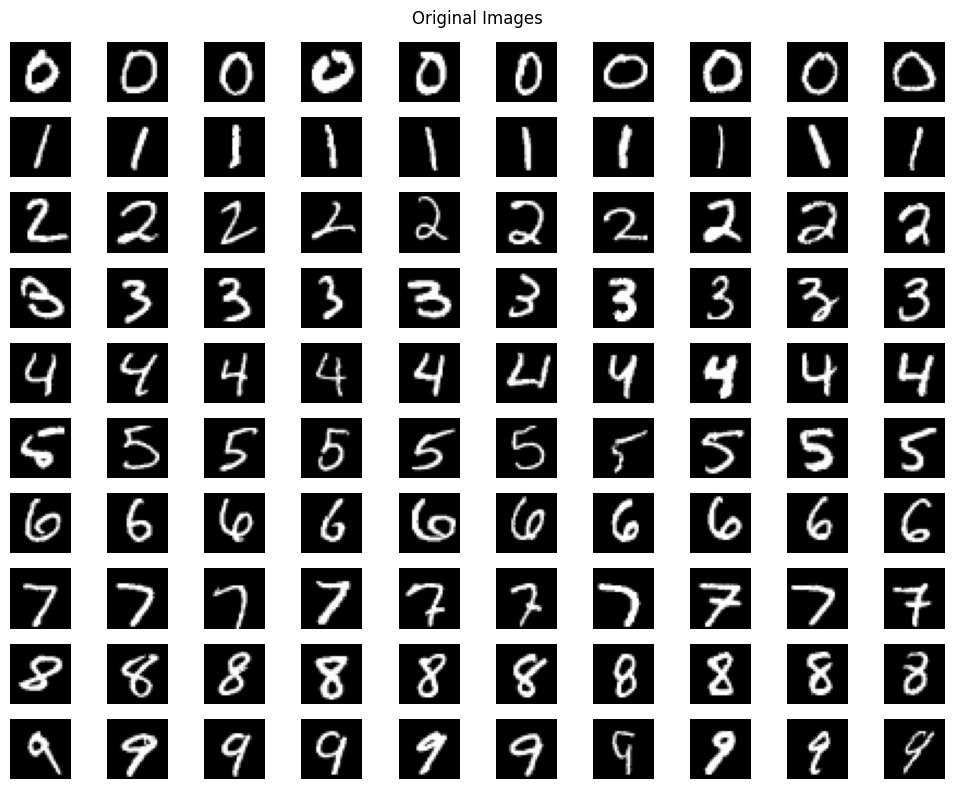

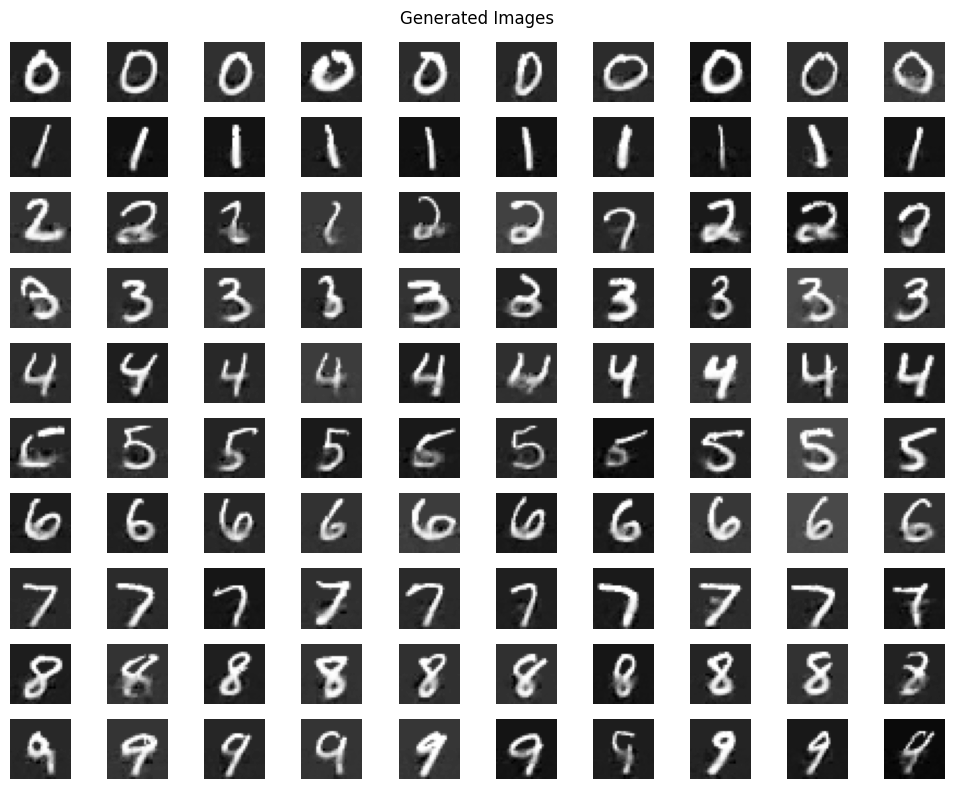

In [24]:
# Visualize the images
visualize_images(original_images, generated_images)

## **Problem 2: Variational Autoencoders on Poor Sevens**

In [25]:
def load_data(train_data_file, test_data_file):
    # Load data from pickle files
    with open(train_data_file, 'rb') as f:
        train_data = pickle.load(f)
    
    with open(test_data_file, 'rb') as f:
        test_data = pickle.load(f)
    
    return train_data, test_data

In [26]:
def prepare_dataset(train_data, test_data):
    # Combine train and test data
    x = np.concatenate((train_data, test_data), axis=0)
    return x

In [27]:
class Q2Dataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32).reshape(data.shape[0], -1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [28]:
# Load data
q2_train_data, q2_test_data = load_data("/kaggle/input/hw5-data-file/hw5_te7.pkl", 
                                "/kaggle/input/hw5-data-file/hw5_tr7.pkl")

In [29]:
# Prepare dataset
processed_data = prepare_dataset(q2_train_data, q2_test_data)

In [30]:
# Create DataLoader
batch_size = 100
q2_train_loader = DataLoader(Q2Dataset(processed_data), 
                             batch_size=batch_size, 
                             shuffle=True)

In [31]:
# Print batch information
q2_batch_x = next(iter(q2_train_loader))
print("Training Data Batch Shape: ", list(q2_batch_x.shape))

Training Data Batch Shape:  [100, 784]


In [32]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=200, latent_dim=3):
        super(VAE, self).__init__()
        
        self.encoder = self._build_encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = self._build_decoder(latent_dim, hidden_dim, input_dim)
        
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.log_var = nn.Linear(hidden_dim, latent_dim)
        
        self._init_weights()

    def _build_encoder(self, input_dim, hidden_dim, latent_dim):
        return nn.Sequential(
            nn.Linear(input_dim, 400),
            nn.LeakyReLU(0.2),
            nn.Linear(400, hidden_dim),
            nn.LeakyReLU(0.2)
        )

    def _build_decoder(self, latent_dim, hidden_dim, output_dim):
        return nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 400),
            nn.LeakyReLU(0.2),
            nn.Linear(400, output_dim),
            nn.Sigmoid()
        )

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def encode(self, x):
        h = self.encoder(x)
        return self.mean(h), self.log_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [33]:
def vae_loss(x_recon, x, mu, log_var, reconstruction_type='mse'):
    def kl_divergence(mu, log_var):
        return -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    if reconstruction_type == 'mse':
        reconstruction_loss = nn.MSELoss(reduction='sum')(x_recon, x)
    elif reconstruction_type == 'bce':
        reconstruction_loss = nn.BCELoss(reduction='sum')(x_recon, x)
    else:
        raise ValueError("Unsupported reconstruction loss type")
    
    kl_div = kl_divergence(mu, log_var)
    total_loss = reconstruction_loss + kl_div
    
    return total_loss, reconstruction_loss, kl_div

In [34]:
def train_q2_model(model, train_loader, optimizer, device, num_epochs=200):
    model.to(device)
    train_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_recon_loss = 0.0
        num_batches = 0
    
        for input_batch in train_loader:
            input_batch = input_batch.to(device)
            
            optimizer.zero_grad()
            
            x_recon, mu, log_var = model(input_batch)
            total_loss, recon_loss, kl_div = vae_loss(x_recon, input_batch, mu, log_var)
            
            total_loss.backward()
            optimizer.step()
    
            epoch_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            num_batches += 1
    
        avg_epoch_loss = epoch_loss / num_batches
        avg_recon_loss = epoch_recon_loss / num_batches
        train_losses.append(avg_epoch_loss)
    
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}')
    
    return train_losses

In [35]:
q2_model = VAE().to(device)
q2_optimizer = torch.optim.Adam(q2_model.parameters(), lr=0.001)

In [36]:
q2_train_losses = train_q2_model(q2_model, q2_train_loader, q2_optimizer, device, num_epochs=200)

Epoch [1/200], Train Loss: 6513.8823, Recon Loss: 6107.2024
Epoch [2/200], Train Loss: 4206.5305, Recon Loss: 3926.7103
Epoch [3/200], Train Loss: 3638.6622, Recon Loss: 3274.8593
Epoch [4/200], Train Loss: 3425.8730, Recon Loss: 3018.7937
Epoch [5/200], Train Loss: 3319.1655, Recon Loss: 2889.0321
Epoch [6/200], Train Loss: 3240.4562, Recon Loss: 2797.9764
Epoch [7/200], Train Loss: 3185.4731, Recon Loss: 2728.8068
Epoch [8/200], Train Loss: 3148.3521, Recon Loss: 2680.9363
Epoch [9/200], Train Loss: 3115.6249, Recon Loss: 2637.7085
Epoch [10/200], Train Loss: 3092.4181, Recon Loss: 2609.2764
Epoch [11/200], Train Loss: 3066.7865, Recon Loss: 2575.0434
Epoch [12/200], Train Loss: 3048.0545, Recon Loss: 2555.2015
Epoch [13/200], Train Loss: 3035.7220, Recon Loss: 2530.9615
Epoch [14/200], Train Loss: 3018.8335, Recon Loss: 2512.4254
Epoch [15/200], Train Loss: 3008.5822, Recon Loss: 2496.2303
Epoch [16/200], Train Loss: 2992.0759, Recon Loss: 2478.7589
Epoch [17/200], Train Loss: 2995.

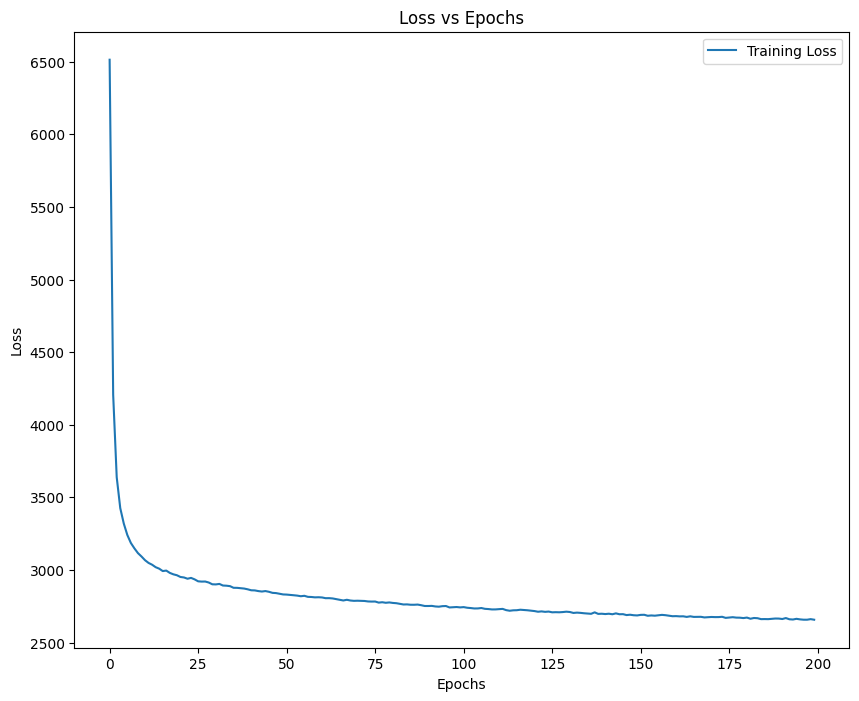

In [37]:
plt.figure(figsize=(10, 8))
plt.title("Loss vs Epochs")
plt.plot(q2_train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [65]:
def visualize_vae_generations(model, latent_dim, device):
    # Generate random images
    random_latents = torch.randn((10, latent_dim)).to(device)
    with torch.no_grad():
        random_images = model.decoder(random_latents)

    # Plot random images
    fig, axes = plt.subplots(2, 5, figsize=(5,2))
    for ax, img in zip(axes.flatten(), random_images):
        ax.imshow(img.cpu().reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.suptitle("Randomly Generated Images")
    plt.tight_layout()
    plt.show()

    # Generate images with varied latent dimensions
    num_variations = 20
    base_latent = torch.randn(latent_dim).to(device)
    variation_range = torch.linspace(-5, 5, num_variations).to(device)

    for dim in range(latent_dim):
        varied_latents = base_latent.repeat(num_variations, 1)
        varied_latents[:, dim] = variation_range

        with torch.no_grad():
            varied_images = model.decoder(varied_latents)

        # Plot varied dimension images
        fig, axes = plt.subplots(2, 10, figsize=(15, 4.5))
        for ax, img in zip(axes.flatten(), varied_images):
            ax.imshow(img.cpu().reshape(28, 28), cmap='gray')
            ax.axis('off')
        plt.suptitle(f"Images with Varied Latent Dimension {dim+1}")
        plt.tight_layout()
        plt.show()

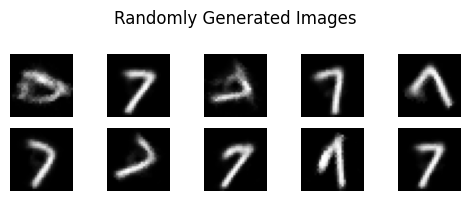

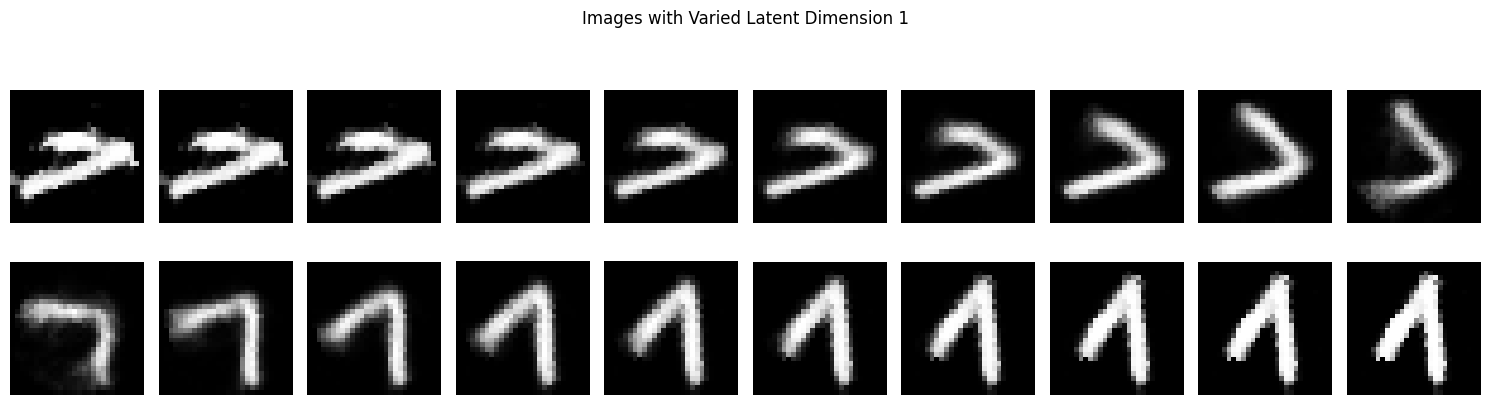

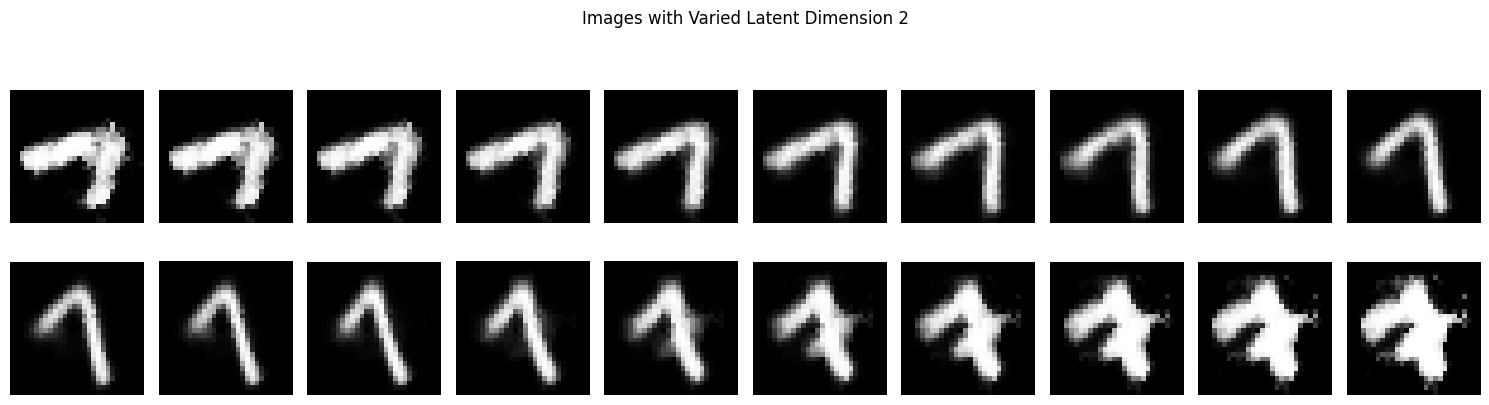

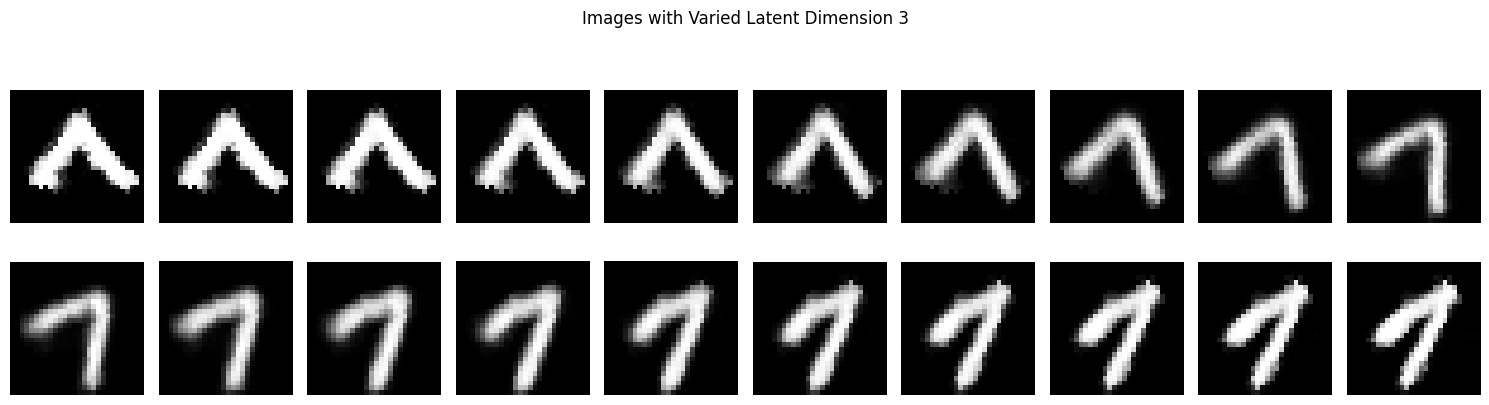

In [66]:
latent_dim = 3
visualize_vae_generations(q2_model, latent_dim, device)

## **Problem 3: Conditional GAN**

In [40]:
# Load MNIST
q3_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets with the transform
q3_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=q3_transform)
q3_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=q3_transform)

# Creata dataloader
q3_train_loader = DataLoader(q3_train_dataset, batch_size=100, shuffle=True)
q3_test_loader = DataLoader(q3_test_dataset, batch_size=100, shuffle=False)

In [41]:
class Generator(nn.Module):
    def __init__(self, ddim_vector=100, num_classes=10):
        super(Generator, self).__init__()
        self.input_dim = ddim_vector + num_classes
        self.linear1 = nn.Linear(self.input_dim, 200)
        self.linear2 = nn.Linear(200, 400)
        self.linear3 = nn.Linear(400, 784)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self._init_weights()
    
    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
                    
    def forward(self, gen_input):
        x = self.linear1(gen_input)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        img = self.tanh(x)
        return img    

In [42]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(Discriminator, self).__init__()
        self.linear1 = nn.Linear(794, 400)
        self.linear2 = nn.Linear(400, 200)
        self.linear3 = nn.Linear(200, 100)
        self.linear4 = nn.Linear(100, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        self._init_weights()

    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, dis_input):
        x = self.linear1(dis_input)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        output = self.sigmoid(x)
        return output

In [43]:
def train_q3_model(generator, discriminator, data_loader, loss_function, generator_optimizer, discriminator_optimizer, device, num_classes=10, num_epochs=100, ddim=100):
    # Track performance metrics
    real_accuracy_per_epoch = []
    fake_accuracy_per_epoch = []

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        
        total_generator_loss = 0.0
        total_discriminator_loss = 0.0
        correct_real_predictions = 0
        correct_fake_predictions = 0
        
        for images, labels in data_loader:
            batch_size = images.size(0)
            images, labels = images.to(device), labels.to(device)
            
            # Flatten images and encode labels
            images = images.view(batch_size, -1)
            one_hot_labels = nn.functional.one_hot(labels, num_classes=num_classes).float().to(device)
            
            # Prepare real and fake inputs
            real_images_with_labels = torch.cat((images, one_hot_labels), dim=1)
            real_labels = torch.ones(batch_size, 1, dtype=torch.float).to(device)
            fake_labels = torch.zeros(batch_size, 1, dtype=torch.float).to(device)
        
            discriminator_optimizer.zero_grad()
            
            # Discriminator forward pass for real images
            real_predictions = discriminator(real_images_with_labels)
            real_loss = loss_function(real_predictions, real_labels)
            real_loss.backward()
            
            # Generate fake images
            random_vector = torch.randn(batch_size, ddim).to(device)
            random_vector_with_labels = torch.cat((random_vector, one_hot_labels), dim=1)
            generated_images = generator(random_vector_with_labels)
            fake_images_with_labels = torch.cat((generated_images, one_hot_labels), dim=1)
            
            # Discriminator forward pass for fake images
            fake_predictions = discriminator(fake_images_with_labels.detach())
            fake_loss = loss_function(fake_predictions, fake_labels)
            fake_loss.backward()
            discriminator_optimizer.step()
        
            generator_optimizer.zero_grad()
            
            # Generator forward pass to fool discriminator
            generator_predictions = discriminator(fake_images_with_labels)
            generator_loss = loss_function(generator_predictions, real_labels)
            generator_loss.backward()
            
            generator_optimizer.step()
            
            # Accumulate losses
            total_discriminator_loss += (real_loss.item() + fake_loss.item()) * batch_size
            total_generator_loss += generator_loss.item() * batch_size
            
            # Accumulate predictions for accuracy calculation
            with torch.no_grad():
                correct_real_predictions += real_predictions.sum().item()
                correct_fake_predictions += fake_predictions.sum().item()
        
        # Calculate epoch-level metrics
        avg_discriminator_loss = total_discriminator_loss / (2 * len(data_loader.dataset))
        avg_generator_loss = total_generator_loss / len(data_loader.dataset)
        
        real_accuracy = correct_real_predictions / len(data_loader.dataset)
        fake_accuracy = correct_fake_predictions / len(data_loader.dataset)

        real_accuracy_per_epoch.append(real_accuracy)
        fake_accuracy_per_epoch.append(fake_accuracy)
        
        # Print metrics for the current epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Dis Loss: {avg_discriminator_loss:.4f}, Gen Loss: {avg_generator_loss:.4f}, '
               f'Real Accuracy: {real_accuracy * 100:.2f}%, Fake Accuracy: {fake_accuracy * 100:.2f}%')

    return avg_discriminator_loss, avg_generator_loss, real_accuracy_per_epoch, fake_accuracy_per_epoch

In [44]:
q3_generator = Generator(100, 10).to(device)
gen_optimizer = torch.optim.Adam(q3_generator.parameters(), lr=0.00015)
q3_disriminator = Discriminator(10).to(device)
dis_optimizer = torch.optim.Adam(q3_disriminator.parameters(), lr=0.00015)
q3_criterion = nn.BCELoss()

q3_dis_loss, q3_gen_loss, q3_real_accu, q3_fake_accu = train_q3_model(
    q3_generator,
    q3_disriminator,
    q3_train_loader,
    q3_criterion,
    gen_optimizer,
    dis_optimizer,
    device
)

Epoch [1/100], Dis Loss: 0.1155, Gen Loss: 4.0485, Real Accuracy: 95.11%, Fake Accuracy: 12.46%
Epoch [2/100], Dis Loss: 0.0643, Gen Loss: 4.7235, Real Accuracy: 95.67%, Fake Accuracy: 5.60%
Epoch [3/100], Dis Loss: 0.0615, Gen Loss: 5.6967, Real Accuracy: 96.09%, Fake Accuracy: 3.93%
Epoch [4/100], Dis Loss: 0.0919, Gen Loss: 4.5497, Real Accuracy: 94.44%, Fake Accuracy: 5.66%
Epoch [5/100], Dis Loss: 0.1078, Gen Loss: 4.2494, Real Accuracy: 93.77%, Fake Accuracy: 6.30%
Epoch [6/100], Dis Loss: 0.0982, Gen Loss: 4.3805, Real Accuracy: 94.40%, Fake Accuracy: 5.54%
Epoch [7/100], Dis Loss: 0.1121, Gen Loss: 4.1853, Real Accuracy: 93.68%, Fake Accuracy: 6.35%
Epoch [8/100], Dis Loss: 0.1173, Gen Loss: 4.1691, Real Accuracy: 93.53%, Fake Accuracy: 6.59%
Epoch [9/100], Dis Loss: 0.1280, Gen Loss: 4.0213, Real Accuracy: 92.89%, Fake Accuracy: 7.35%
Epoch [10/100], Dis Loss: 0.1621, Gen Loss: 3.6776, Real Accuracy: 90.86%, Fake Accuracy: 9.30%
Epoch [11/100], Dis Loss: 0.1700, Gen Loss: 3.46

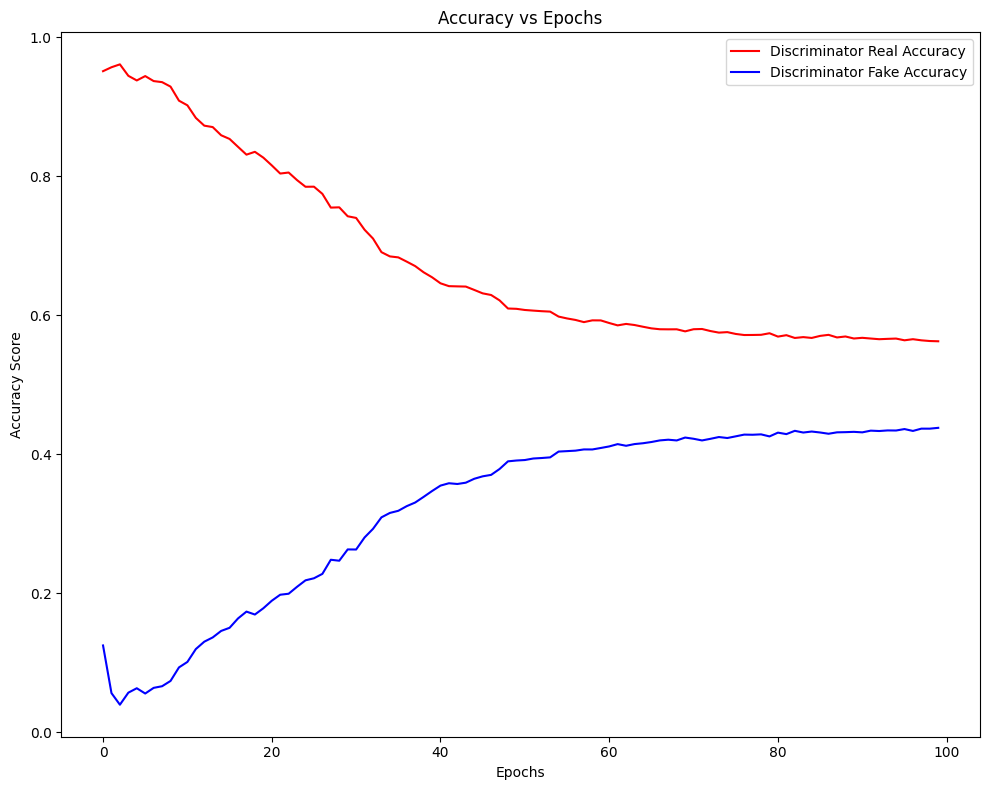

In [45]:
plt.figure(figsize=(10, 8))
plt.plot(q3_real_accu, label='Discriminator Real Accuracy', color='red')
plt.plot(q3_fake_accu, label='Discriminator Fake Accuracy', color='blue')
plt.title('Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
def q3_generate_images(generator, ddim, num_classes, device, samples_per_class=10):
    # Prepare one-hot encoded class labels
    one_hot_labels = nn.functional.one_hot(
        torch.arange(num_classes).repeat_interleave(samples_per_class), 
        num_classes=num_classes
    ).float().to(device)
    
    # Generate random latent vectors
    random_vectors = torch.randn(num_classes * samples_per_class, ddim, device=device)
    
    # Combine latent vectors with class labels
    generator_input = torch.cat((random_vectors, one_hot_labels), dim=1)
    
    # Generate fake images
    with torch.no_grad():
        generator.eval()
        generated_images = generator(generator_input)
    
    return generated_images.cpu().numpy()

In [47]:
q3_fake_images = q3_generate_images(q3_generator, 100, 10, device)

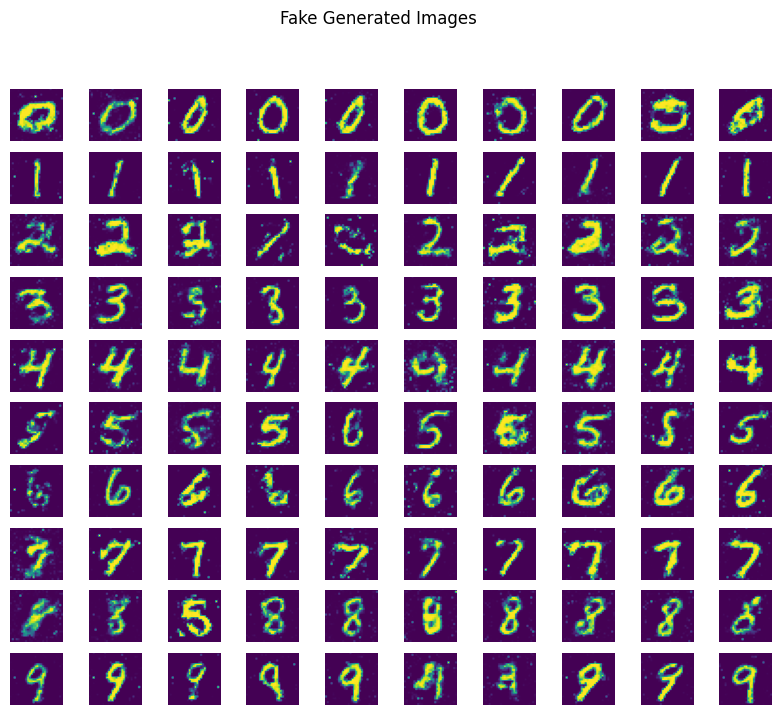

In [48]:
plt.figure(figsize=(10, 8))
plt.suptitle("Fake Generated Images")
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(q3_fake_images[i].reshape(28, 28))
    plt.axis('off')
plt.show()

## **Problem 4: Missing Value Imputation using Conditional GAN**

In [49]:
# Load MNIST
q4_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets with the transform
q4_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=q4_transform)
q4_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=q4_transform)

# Creata dataloader
q4_train_loader = DataLoader(q4_train_dataset, batch_size=100, shuffle=True)
q4_test_loader = DataLoader(q4_test_dataset, batch_size=100, shuffle=False)

In [50]:
class Q4Generator(nn.Module):
    def __init__(self):
        super(Q4Generator, self).__init__()
        self.linear1 = nn.Linear(200, 1024)
        self.linear2 = nn.Linear(1024, 2048)
        self.linear3 = nn.Linear(2048, 1024)
        self.linear4 = nn.Linear(1024, 784)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self._init_weights()
    
    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
                    
    def forward(self, gen_input):
        x = self.linear1(gen_input)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        img = self.tanh(x)
        return img    

In [51]:
class Q4Discriminator(nn.Module):
    def __init__(self):
        super(Q4Discriminator, self).__init__()
        self.linear1 = nn.Linear(784, 2048)
        self.linear2 = nn.Linear(2048, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.linear4 = nn.Linear(512, 256)
        self.linear5 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        self._init_weights()
    
    def _init_weights(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)
                    
    def forward(self, dis_input):
        x = self.linear1(dis_input)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear5(x)
        img = self.sigmoid(x)
        return img    

In [52]:
def train_q4_model(generator, discriminator, data_loader, loss_function, generator_optimizer, discriminator_optimizer, device, lam=0.1, num_classes=10, num_epochs=100, ddim=100):
    # Track performance metrics
    real_accuracy_per_epoch = []
    fake_accuracy_per_epoch = []

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        
        total_generator_loss = 0.0
        total_discriminator_loss = 0.0
        correct_real_predictions = 0
        correct_fake_predictions = 0
        
        for images, labels in data_loader:
            batch_size = images.size(0)
            images, labels = images.to(device), labels.to(device)
            
            # Flatten images
            images = images.view(batch_size, -1)
            
            # Prepare discriminator targets
            real_labels = torch.ones(batch_size, 1, dtype=torch.float).to(device)
            fake_labels = torch.zeros(batch_size, 1, dtype=torch.float).to(device)
        
            discriminator_optimizer.zero_grad()
            
            # Discriminator forward pass for real images
            real_predictions = discriminator(images)
            real_loss = loss_function(real_predictions, real_labels)
            real_loss.backward()
            
            # Generate fake images
            random_vector = torch.randn(batch_size, ddim).to(device)
            center_patches = images.reshape(images.size(0), 1, 28, 28)
            center_patches = center_patches[:, :, 9:19, 9:19].reshape(center_patches.size(0), -1)
            random_vector_with_center_patch = torch.cat((random_vector, center_patches), dim=1)
            generated_images = generator(random_vector_with_center_patch)
            
            # Discriminator forward pass for fake images
            fake_predictions = discriminator(generated_images.detach())
            fake_loss = loss_function(fake_predictions, fake_labels)
            fake_loss.backward()
            discriminator_optimizer.step()
        
            generator_optimizer.zero_grad()
            
            # Generator forward pass to fool discriminator
            generator_predictions = discriminator(generated_images)
            
            # BCE loss + MSE loss for patch condition
            pred_patches = generated_images.reshape(images.size(0), 1, 28, 28)
            pred_patches = pred_patches[:, :, 9:19, 9:19].reshape(pred_patches.size(0), -1)
            mse_loss = nn.MSELoss()
            generator_loss = loss_function(generator_predictions, real_labels) + lam * mse_loss(pred_patches, center_patches)

            generator_loss.backward()
            
            generator_optimizer.step()
            
            # Accumulate losses
            total_discriminator_loss += (real_loss.item() + fake_loss.item()) * batch_size
            total_generator_loss += generator_loss.item() * batch_size
            
            # Accumulate predictions for accuracy calculation
            with torch.no_grad():
                correct_real_predictions += real_predictions.sum().item()
                correct_fake_predictions += fake_predictions.sum().item()
        
        # Calculate epoch-level metrics
        avg_discriminator_loss = total_discriminator_loss / (2 * len(data_loader.dataset))
        avg_generator_loss = total_generator_loss / len(data_loader.dataset)
        
        real_accuracy = correct_real_predictions / len(data_loader.dataset)
        fake_accuracy = correct_fake_predictions / len(data_loader.dataset)

        real_accuracy_per_epoch.append(real_accuracy)
        fake_accuracy_per_epoch.append(fake_accuracy)
 
        # Print metrics for the current epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Dis Loss: {avg_discriminator_loss:.4f}, Gen Loss: {avg_generator_loss:.4f}, '
               f'Real Accuracy: {real_accuracy * 100:.2f}%, Fake Accuracy: {fake_accuracy * 100:.2f}%')

    return avg_discriminator_loss, avg_generator_loss, real_accuracy_per_epoch, fake_accuracy_per_epoch

In [54]:
q4_generator_01 = Q4Generator().to(device)
q4_gen_optimizer_01 = torch.optim.Adam(q4_generator_01.parameters(), lr=0.00015)
q4_discriminator_01 = Q4Discriminator().to(device)
q4_dis_optimizer_01 = torch.optim.Adam(q4_discriminator_01.parameters(), lr=0.00015)
q4_criterion = nn.BCELoss()

lam = 0.1

q4_dis_loss_01, q4_gen_loss_01, q4_real_acc_01, q4_fake_accu_01 = train_q4_model(
    q4_generator_01, 
    q4_discriminator_01, 
    q4_train_loader, 
    q4_criterion, 
    q4_gen_optimizer_01,
    q4_dis_optimizer_01,
    device,
    lam    
)

Epoch [1/100], Dis Loss: 0.1132, Gen Loss: 7.9315, Real Accuracy: 95.74%, Fake Accuracy: 9.31%
Epoch [2/100], Dis Loss: 0.0257, Gen Loss: 8.3450, Real Accuracy: 98.80%, Fake Accuracy: 1.82%
Epoch [3/100], Dis Loss: 0.0315, Gen Loss: 9.0395, Real Accuracy: 98.37%, Fake Accuracy: 1.85%
Epoch [4/100], Dis Loss: 0.0473, Gen Loss: 8.2522, Real Accuracy: 97.52%, Fake Accuracy: 2.57%
Epoch [5/100], Dis Loss: 0.0466, Gen Loss: 7.1411, Real Accuracy: 97.49%, Fake Accuracy: 2.52%
Epoch [6/100], Dis Loss: 0.0519, Gen Loss: 6.2988, Real Accuracy: 97.21%, Fake Accuracy: 2.74%
Epoch [7/100], Dis Loss: 0.0800, Gen Loss: 5.3375, Real Accuracy: 95.64%, Fake Accuracy: 4.34%
Epoch [8/100], Dis Loss: 0.0955, Gen Loss: 4.6789, Real Accuracy: 94.66%, Fake Accuracy: 5.34%
Epoch [9/100], Dis Loss: 0.1126, Gen Loss: 4.2327, Real Accuracy: 93.76%, Fake Accuracy: 6.33%
Epoch [10/100], Dis Loss: 0.1450, Gen Loss: 3.5657, Real Accuracy: 91.79%, Fake Accuracy: 8.26%
Epoch [11/100], Dis Loss: 0.1648, Gen Loss: 3.263

In [55]:
q4_generator_10 = Q4Generator().to(device)
q4_gen_optimizer_10 = torch.optim.Adam(q4_generator_10.parameters(), lr=0.00015)
q4_discriminator_10 = Q4Discriminator().to(device)
q4_dis_optimizer_10 = torch.optim.Adam(q4_discriminator_10.parameters(), lr=0.00015)

lam = 10

q4_dis_loss_10, q4_gen_loss_10, q4_real_acc_10, q4_fake_accu_10 = train_q4_model(
    q4_generator_10, 
    q4_discriminator_10, 
    q4_train_loader, 
    q4_criterion, 
    q4_gen_optimizer_10,
    q4_dis_optimizer_10,
    device,
    lam    
)

Epoch [1/100], Dis Loss: 0.2164, Gen Loss: 13.6637, Real Accuracy: 90.05%, Fake Accuracy: 15.82%
Epoch [2/100], Dis Loss: 0.1494, Gen Loss: 9.4539, Real Accuracy: 92.05%, Fake Accuracy: 9.62%
Epoch [3/100], Dis Loss: 0.1940, Gen Loss: 7.2635, Real Accuracy: 88.46%, Fake Accuracy: 11.57%
Epoch [4/100], Dis Loss: 0.2611, Gen Loss: 4.9205, Real Accuracy: 83.90%, Fake Accuracy: 15.95%
Epoch [5/100], Dis Loss: 0.3221, Gen Loss: 3.6946, Real Accuracy: 79.68%, Fake Accuracy: 20.45%
Epoch [6/100], Dis Loss: 0.3590, Gen Loss: 3.1866, Real Accuracy: 77.16%, Fake Accuracy: 23.14%
Epoch [7/100], Dis Loss: 0.4183, Gen Loss: 2.6018, Real Accuracy: 72.90%, Fake Accuracy: 27.63%
Epoch [8/100], Dis Loss: 0.4471, Gen Loss: 2.2861, Real Accuracy: 70.68%, Fake Accuracy: 29.65%
Epoch [9/100], Dis Loss: 0.4626, Gen Loss: 2.1275, Real Accuracy: 69.54%, Fake Accuracy: 30.77%
Epoch [10/100], Dis Loss: 0.4779, Gen Loss: 1.9774, Real Accuracy: 68.42%, Fake Accuracy: 32.03%
Epoch [11/100], Dis Loss: 0.5066, Gen L

In [56]:
# Generate random input
random_vector = torch.randn(100, 100).to(device)

# Use the sample_by_class function to get 10 images per digit
class_samples = sample_by_class(q4_test_loader, sample_size=10)

# Create an ordered list of images
real_imgs = []
for digit in range(10):  # 0 to 9
    real_imgs.extend([sample[0] for sample in class_samples[digit]])

# Convert to tensor and move to device
real_imgs = torch.stack(real_imgs).to(device)

# Extract center patches as condition
center_patches = real_imgs.view(100, 1, 28, 28)
center_patches = center_patches[:, :, 9:19, 9:19].reshape(100, -1)

# Concatenate random input with condition
gen_input = torch.cat((random_vector, center_patches), dim=1)

In [57]:
# Generate fake images with q4_generator_01
q4_generator_01.eval()
with torch.no_grad():
    q4_fake_images_01 = q4_generator_01(gen_input)
q4_fake_images_01 = q4_fake_images_01.cpu().numpy()

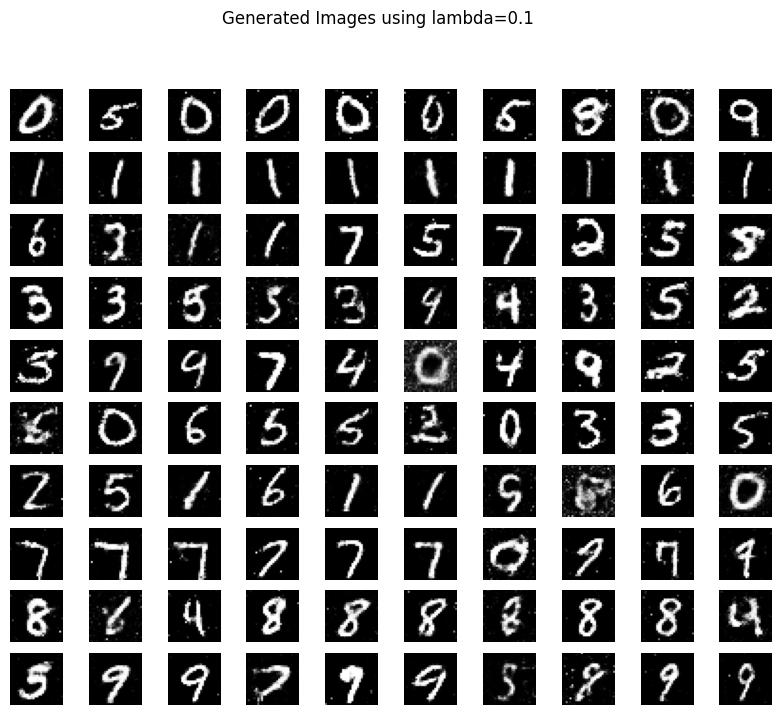

In [58]:
plt.figure(figsize=(10, 8))
plt.suptitle("Generated Images using lambda=0.1")
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(q4_fake_images_01[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

In [59]:
# Generate fake images with q4_generator_10
q4_generator_10.eval()
with torch.no_grad():
    q4_fake_images_10 = q4_generator_10(gen_input)
q4_fake_images_10 = q4_fake_images_10.cpu().numpy()

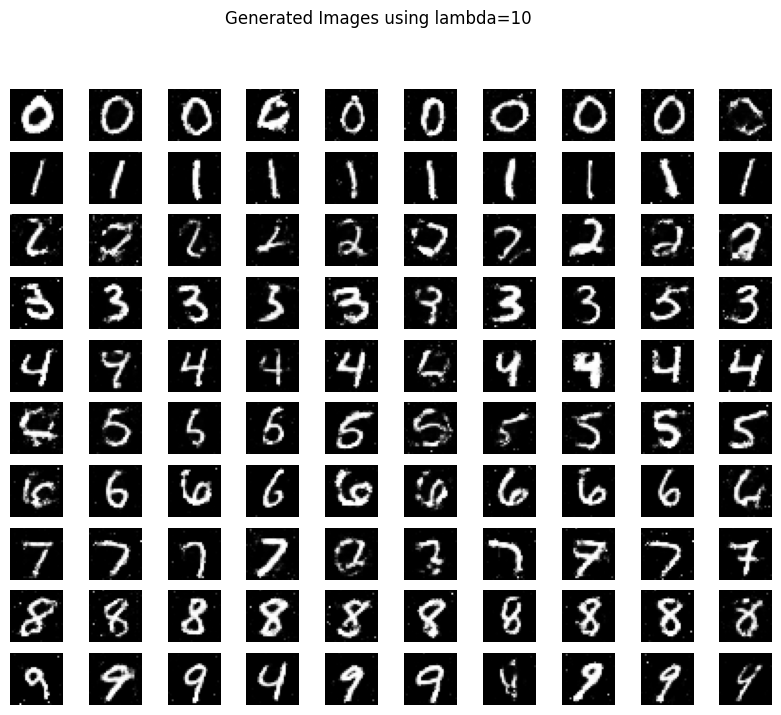

In [60]:
plt.figure(figsize=(10, 8))
plt.suptitle("Generated Images using lambda=10")
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(q4_fake_images_10[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()